## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from models.neuralnetwork.spherical_cnn import SCNNModel
from preprocessing.data_augmentation import extend_dataset_with_origin_reflections
from preprocessing.data_transformations import convert_coords_from_cartesian_to_spherical
from sphericalharmonics.spherical_fourier_transform import get_spherical_fourier_transform
from sphericalharmonics.spherical_fourier_transform import get_design_matrix
from sphericalharmonics.spherical_fourier_transform import get_inverse_spherical_fourier_transform

# Spherical convolutional neural network for fODF estimation

## Hyperparameters

In [2]:
number_of_shells = 1
output_size = 45
learning_rate = 0.001
final_learning_rate = 0.0001
batch_size = 1000
num_batches = 10000
num_batches_lr_reduction = 10000
max_degree = 8

## Load dataset

In [3]:
all_dwis = np.load('./data/planar/no_rotation/diffusion_weighted_signals.npy')
all_fODFs = np.load('./data/planar/no_rotation/fODF_sh_coefficients.npy')
all_qhat = np.load('./data/planar/no_rotation/gradient_orientations.npy')
all_bvals = np.load('./data/planar/no_rotation/b_values.npy')
all_dwis_sh_coefficients = np.load("./data/planar/no_rotation/diffusion_weighted_signals_sh_coefficients.npy")

## Pre-processing

In [4]:
thetas, phis = convert_coords_from_cartesian_to_spherical(all_qhat[0])

## Compute spherical Fourier transform

In [5]:
design_matrix = get_design_matrix(max_degree = max_degree ,number_of_samples=len(all_bvals[0]), thetas=thetas, phis=phis)
spherical_fourier_transform = get_spherical_fourier_transform(design_matrix)

## Compute inverse spherical Fourier transform

In [6]:
inverse_spherical_fourier_transform = get_inverse_spherical_fourier_transform(design_matrix)

## Convert numpy arrays to tensors

In [7]:
spherical_fourier_transform = torch.from_numpy(spherical_fourier_transform).float()
inverse_spherical_fourier_transform = torch.from_numpy(inverse_spherical_fourier_transform).float()

## Train the S-CNN

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


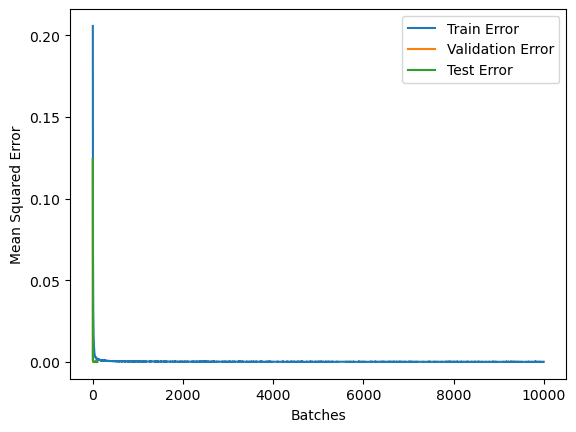

In [8]:
all_dwis_sh_coefficients = np.expand_dims(all_dwis_sh_coefficients,1)

# Create the neural network
model = SCNNModel(number_of_shells, output_size, max_degree, spherical_fourier_transform, inverse_spherical_fourier_transform)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Data arrays
train_data = all_dwis_sh_coefficients[:60000]
train_targets = all_fODFs[:60000]
val_data = all_dwis_sh_coefficients[60000:80000]
val_targets = all_fODFs[60000:80000]
test_data = all_dwis_sh_coefficients[80000:]
test_targets = all_fODFs[80000:]

# Lists to store errors for plotting
train_errors = []
val_errors = []
test_errors = []

device = torch.device('mps')
model.to(device)

# Training loop
for batch in range(num_batches):
    
    if(batch % 1000 == 0):
        print(batch)
    
    # Adjust learning rate
    if batch == num_batches - num_batches_lr_reduction:
        for param_group in optimizer.param_groups:
            param_group['lr'] = final_learning_rate

    indices = torch.randperm(len(train_data))[:batch_size]

    inputs = torch.FloatTensor(train_data[indices])
    targets = torch.FloatTensor(train_targets[indices])
    
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_errors.append(loss.item())

    # Calculate validation and test errors
    if batch % 100 == 0:
        with torch.no_grad():
            val_inputs = torch.FloatTensor(val_data).to(device)
            val_target = torch.FloatTensor(val_targets).to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_target)
            val_errors.append(val_loss.item())

            test_inputs = torch.FloatTensor(test_data).to(device)
            test_target = torch.FloatTensor(test_targets).to(device)
            test_outputs = model(test_inputs)
            test_loss = criterion(test_outputs, test_target)
            test_errors.append(test_loss.item())

# Plot errors
plt.plot(train_errors, label='Train Error')
plt.plot(val_errors, label='Validation Error')
plt.plot(test_errors, label='Test Error')
plt.xlabel('Batches')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Save model weights
#torch.save(model.state_dict(), './model_weights.pth')

## Load data with rotations

In [9]:
all_dwis = np.load('./data/planar/rotation/diffusion_weighted_signals.npy')
all_fODFs = np.load('./data/planar/rotation/fODF_sh_coefficients.npy')
all_qhat = np.load('./data/planar/rotation/gradient_orientations.npy')
all_bvals = np.load('./data/planar/rotation/b_values.npy')
all_dwis_sh_coefficients = np.load("./data/planar/no_rotation/diffusion_weighted_signals_sh_coefficients.npy")
all_dwis_sh_coefficients = np.expand_dims(all_dwis_sh_coefficients,1)

## Model evaluation

In [10]:
rotated_inputs = torch.FloatTensor(all_dwis_sh_coefficients[:10000]).to(device)
rotated_target = torch.FloatTensor(all_fODFs[:10000]).to(device)
rotated_outputs = model(rotated_inputs)
rotated_loss = criterion(rotated_outputs, rotated_target)
rotated_loss.item()

0.06813320517539978

In [11]:
test_errors[-1]

4.748035280499607e-05

In [12]:
rotated_loss.item() / test_errors[-1]

1434.976809359987

In [2]:
from functools import partial
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
import pandas as pd

from models.sphericaldeconvolution.spherical_deconvolution import spherical_deconvolution_fit
from models.sphericaldeconvolution.fibre_response_function import simple_fibre_response_function, diffusion_tensor_response_function
from dataloader.load_dt_simulated import load_dt_simulated_multiple_populations
from preprocessing.data_augmentation import extend_dataset_with_origin_reflections
from preprocessing.data_transformations import convert_coords_from_cartesian_to_spherical
from visualization.spherical_functions_visualisation import get_spherical_function_values_from_spherical_expansion

[[ 0.42147651  0.17607473  0.8895815 ]
 [ 0.88032803  0.24013768 -0.40909224]
 [ 0.28600201 -0.95671432  0.05385689]]


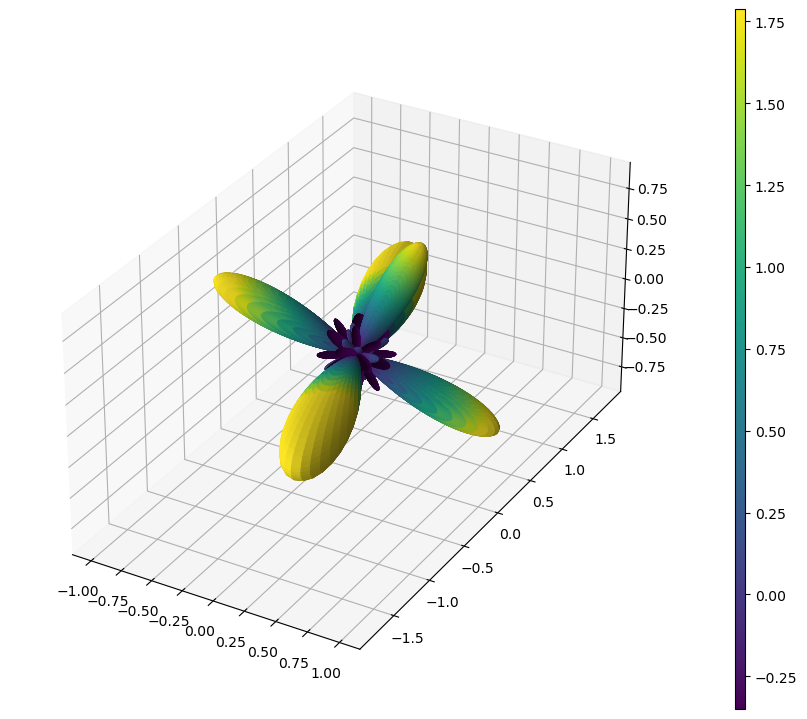

In [35]:
#%matplotlib qt

fODFs = np.load('./data/planar/rotation/fODF_sh_coefficients.npy')
fibre_orientations = np.load('./data/planar/rotation/fibre_orientations.npy')

index = 20340

print(fibre_orientations[index])

x, y, z, fcolors = get_spherical_function_values_from_spherical_expansion(fODFs[index],max_degree=8,resolution=200,min_value=None,max_value=None, normalize=False)

x = x * fcolors
y = y * fcolors
z = z * fcolors

fig = plt.figure(figsize=(10,10))

cmap = plt.cm.viridis
normalization = Normalize(vmin=np.min(fcolors), vmax=np.max(fcolors))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalization)

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=plt.cm.viridis(fcolors), shade=True)
#ax.set_axis_off()
plt.gca().set_aspect('equal')

#ax.plot([-0.99834138,0],[-0.0575716,0],[0,0])
#ax.plot([-0.57181506,0],[-0.82038256,0],[0,0])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, ax=[ax], cax=cbar_ax)

plt.show()